# Importing modules

In [1]:
import re
import numpy as np
import pandas as pd

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to C:\Users\zakbh.DESKTOP-
[nltk_data]     MLIH5S0\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\zakbh.DESKTOP-
[nltk_data]     MLIH5S0\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# importing dataset

In [3]:
# Importing the dataset
columns = ['target','ids','date','flag','user','text']
df = pd.read_csv(r'C:\Users\zakbh.DESKTOP-MLIH5S0\Downloads\training.1600000.processed.noemoticon.csv\training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', names=columns)
df.sample(5)

,target,ids,date,flag,user,text
13240,0,1553170160,Sat Apr 18 13:33:21 PDT 2009,NO_QUERY,paul_burger,Lost $90 in cash at the mall today. Fell out o...
751030,0,2285897658,Mon Jun 22 15:43:44 PDT 2009,NO_QUERY,ElaineMcDonald,My computer mouse is smarter than I am It say...
1011989,4,1881158892,Fri May 22 03:47:48 PDT 2009,NO_QUERY,SimonLYW,HULU is coming to the UK!
795139,0,2327247350,Thu Jun 25 08:06:19 PDT 2009,NO_QUERY,Loleets,@insearchofnkotb FYI - &quot;My Sister's Keepe...
307307,0,2000442020,Mon Jun 01 22:07:26 PDT 2009,NO_QUERY,vbarbu,@MoL42 be careful! i just traced my sickness b...


# Performing EDA

In [4]:
df.shape

(1600000, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [6]:
df.nunique()

target          2
ids       1598315
date       774363
flag            1
user       659775
text      1581466
dtype: int64

In [7]:
df.drop(['ids','date','flag','user'], axis=1, inplace=True)
df.sample(5)

,target,text
576632,0,@walterelly Any luck with your iPhone shipping...
974272,4,@josephranseth when you wake up not for yourse...
358829,0,Just got back from Greece! Wish i was still th...
933043,4,@JKs_Fix lol thank you!
1117123,4,Just got invited to do the next papernstitch e...


In [8]:
df.shape

(1600000, 2)

In [9]:
df["target"].unique()

array([0, 4], dtype=int64)

In [10]:
df["target"] = df['target'].replace(4,1)
df["target"].unique()

array([0, 1], dtype=int64)

In [11]:
target_counts = df['target'].value_counts()

positive_tweets = target_counts[1]
negative_tweets = target_counts[0]

print(f'Positive Tweets: {positive_tweets} \nNegative Tweets: {negative_tweets}')

Positive Tweets: 800000 
Negative Tweets: 800000


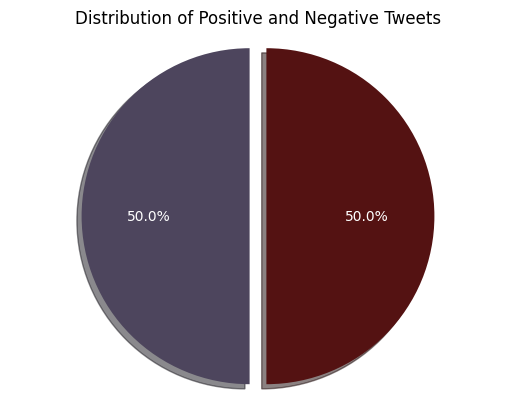

In [14]:
labels = ['Positive', 'Negative']
sizes = [positive_tweets, negative_tweets]
colors = ['#4D455D', '#541212']
explode = (0.1, 0)  # Explode the Positive slice

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90, textprops={'color': 'white'})
plt.axis('equal')  # Equal aspect ratio ensures a circular pie chart

plt.title('Distribution of Positive and Negative Tweets')
plt.show()

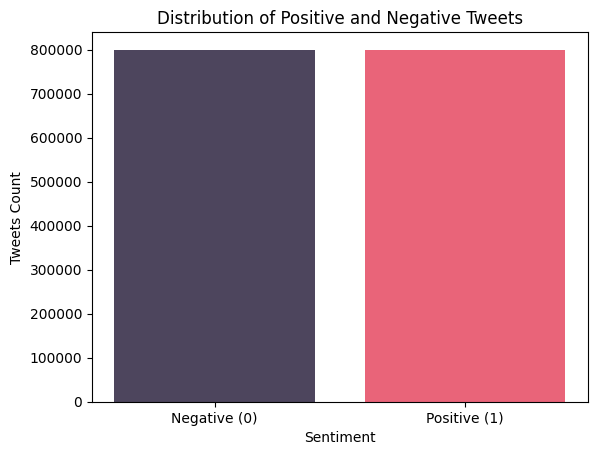

In [15]:
labels = ['Negative (0)', 'Positive (1)']
counts = [negative_tweets, positive_tweets]
colors = ['#4D455D', '#E96479']

plt.bar(labels, counts, color=colors)

plt.xlabel('Sentiment')
plt.ylabel('Tweets Count')
plt.title('Distribution of Positive and Negative Tweets')

plt.show()

In [16]:
from sklearn.utils import shuffle

dataset = df.copy()
dataset = shuffle(dataset)
dataset.sample(5)

,target,text
1345720,1,#followfiday @ricewab - if you want some no BS...
65076,0,@carlmayer I love This American Life but I lis...
739826,0,@lucan20 Oh no. That's tough. Please give her...
1289793,1,Reading up on Reiki in the sun
1191330,1,"@Donnette Of course, Donette! All you need to ..."


In [17]:
dataset.shape

(1600000, 2)

# Data Preprocessing


## **3. Data Preprocessing:**##

`text_preprocessing` function has been created which is used for following tasks

*   Making all the tweets lowercase
*   Replacing all urls with ' '
*   Replacing all twitter handles (@someone) with ' '
*   Replacing all special characters with ' '
*   Replacing 3 or more consecutive letters with 3 (oooooh to ooh)
*   Removing stop words from tweets (the, she..)
*   Removing words of length less than 2
*   Lemmatizing the words (hours to hour)

In [18]:
def text_preprocessing(text):
    processed_tweets = []

    # Defining stopwords list
    stopwords_list = set(stopwords.words('english'))

    # Creating lemmatizer
    lm = WordNetLemmatizer()

    # Defining regex patterns.
    urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern = '@[\w]*'
    alphabetPattern = "[^a-zA-Z0-9]"
    sequencePattern = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    for tweet in text:
        tweet = tweet.lower()

        tweet = re.sub(urlPattern, ' ', tweet)
        tweet = re.sub(userPattern, ' ', tweet)
        tweet = re.sub(alphabetPattern, " ", tweet)
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            if word not in stopwords_list and len(word) > 1:
                word = lm.lemmatize(word)
                tweetwords += (word+' ')
        
        processed_tweets.append(tweetwords)

    return processed_tweets


In [19]:
dataset["text"] = text_preprocessing(dataset["text"])
dataset.sample(5)

,target,text
1023972,1,thanks mention followfriday
1514774,1,break heart went beatport top 100 house chart ...
1015963,1,happy birffday son great weekend
1140097,1,great wedding shoot today drinking mill street...
687861,0,rather brainstorming 600 word chinese essay haha


In [20]:
dataset = dataset[dataset["text"].apply(len) > 0]
dataset.shape

(1591732, 2)

## Creating a WordCloud for all Tweets

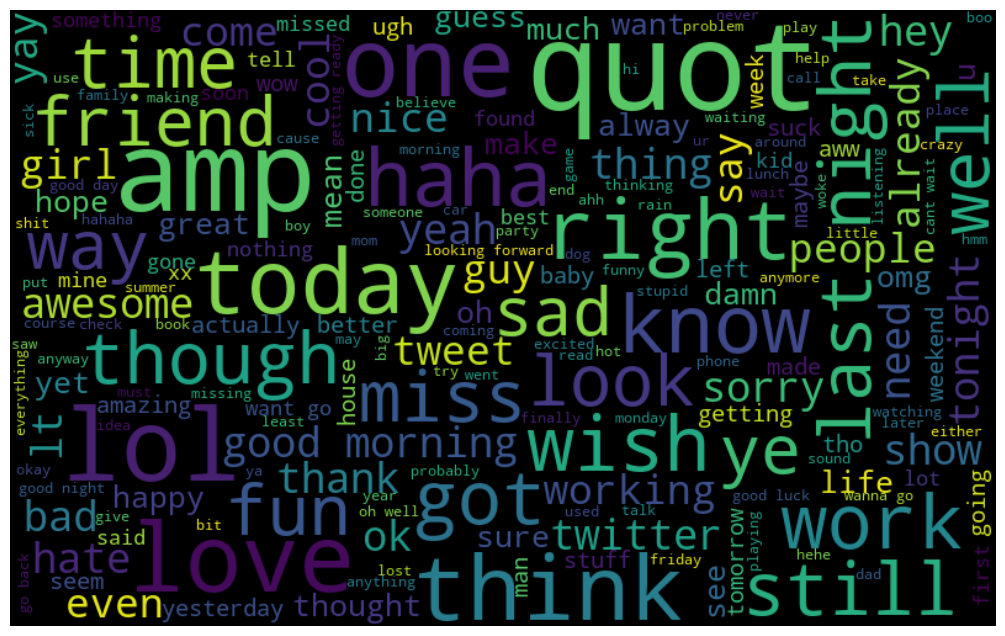

In [21]:
# Creating Word Cloud for all tweets

all_words = ' '.join(dataset['text'])
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Creating WordCloud for all Positive Tweets

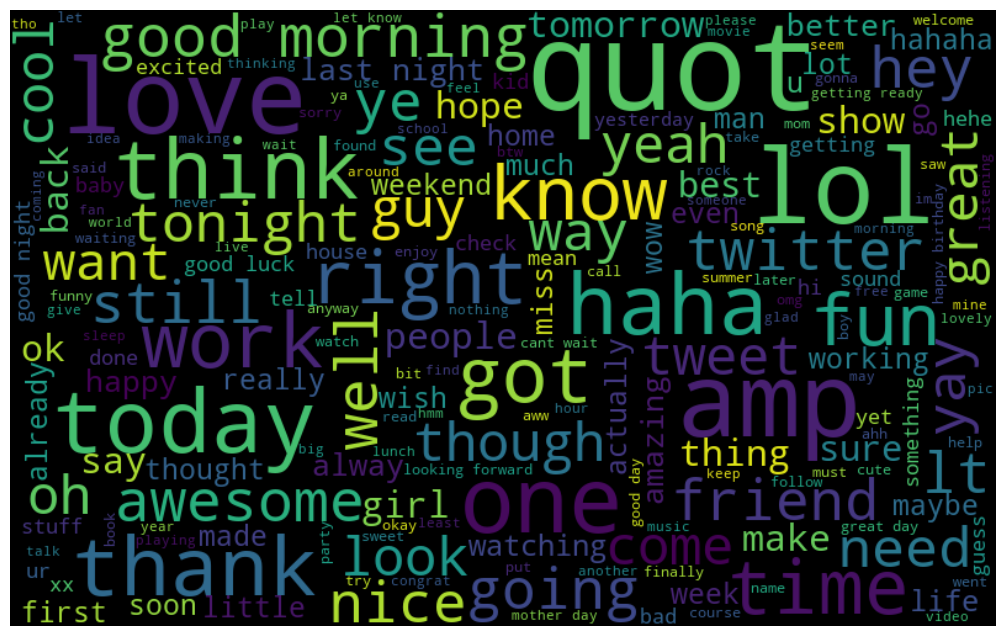

In [22]:
# Creating Word Cloud for all positive tweets

text_pos = dataset.loc[dataset['target'] == 1, 'text']
all_pos_words = ' '.join(text_pos)

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_pos_words)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

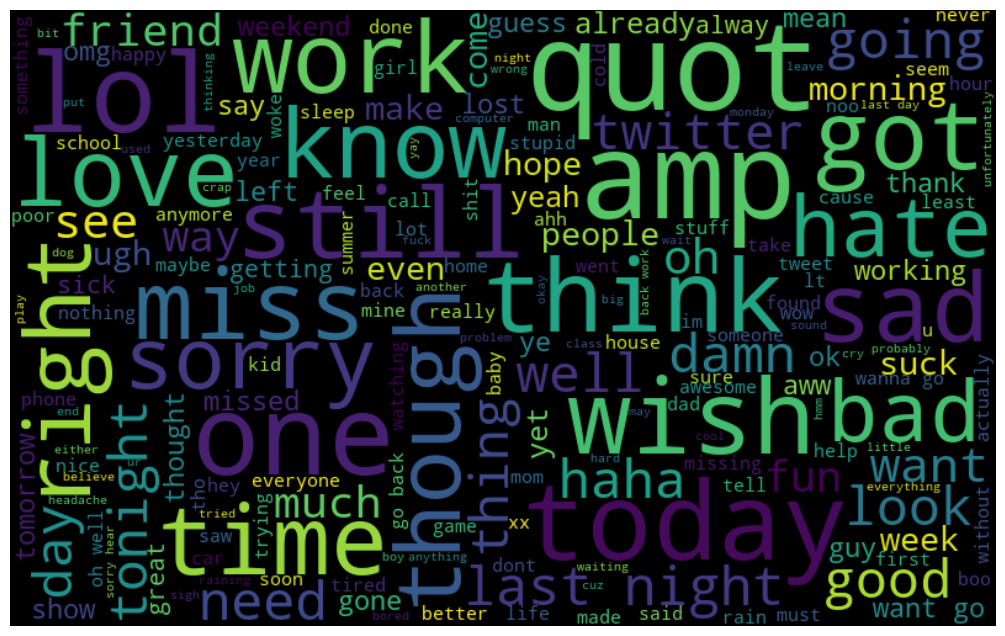

In [23]:
# Creating Word Cloud for all negative tweets

text_neg = dataset.loc[dataset['target'] == 0, 'text']
all_neg_words = ' '.join(text_neg)

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_neg_words)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Splitting the dataset into Train and Test

In [24]:
# Splitting the dataset into features and target

X = dataset["text"]
y = dataset["target"]

In [25]:
# Spliting dataset into Train and test datasets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Extraction using TfidVectorizer

In [26]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=500000, stop_words='english')

vectorizer.fit_transform(X_train)
print('No. of feature_words:', len(vectorizer.get_feature_names_out()))

No. of feature_words: 500000


In [27]:
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

# Model Training and Evaluation

### Evaluation Metrics used:
### Precision
### Recall
### Confusion Matrix

In [28]:
def evaluate_model(model):
    
    y_pred = model.predict(X_test)

    print("*****************************************\nCLASSIFICATION REPORT\n*****************************************")
    print(classification_report(y_test, y_pred))
    

    print("\n*****************************************\nCONFUSION MATRIX\n*****************************************")
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)

*****************************************
CLASSIFICATION REPORT
*****************************************
              precision    recall  f1-score   support

           0       0.79      0.77      0.78    159074
           1       0.77      0.80      0.79    159273

    accuracy                           0.78    318347
   macro avg       0.78      0.78      0.78    318347
weighted avg       0.78      0.78      0.78    318347


*****************************************
CONFUSION MATRIX
*****************************************


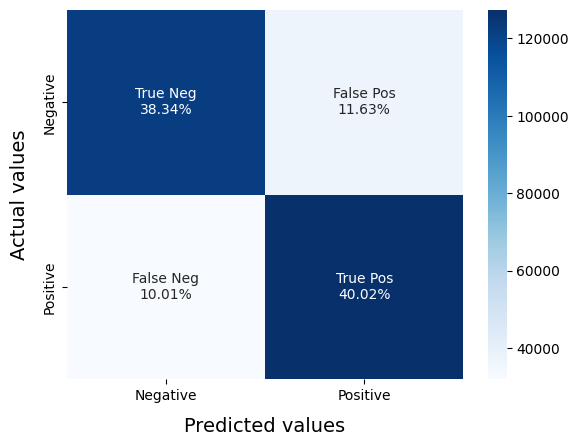

In [29]:
lr = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
lr.fit(X_train, y_train)
evaluate_model(lr)

In [30]:
def predict(vectoriser, model, text):

    textdata = vectoriser.transform(text_preprocessing(text))
    target = model.predict(textdata)
    
    data = []
    for text, pred in zip(text, target):
        data.append((text, pred))
        
    df = pd.DataFrame(data, columns = ['text','target'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

In [31]:
test_tweets = ["I hate twitter",
        "May the Force be with you.",
        "Mr Elon, I love this bird app!!"]

df_test = predict(vectorizer, lr, test_tweets)
print(df_test.head())

                              text    target
0                   I hate twitter  Negative
1       May the Force be with you.  Positive
2  Mr Elon, I love this bird app!!  Positive
